### Libraries

In [1]:
import yfinance as yf
import plotly.graph_objs as go
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

# _Bitcoin Analysis_


##  I)- Visualization 


In [52]:
data.head()

,Open,High,Low,Close,Adj Close,Volume,Close_diff
Date,,,,,,,
2019-11-13,8812.033203,8836.841797,8761.651367,8808.262695,8808.262695,17545755405,-7.399414
2019-11-14,8811.936523,8826.943359,8692.551758,8708.094727,8708.094727,19084739975,-100.167969
2019-11-15,8705.708008,8730.873047,8484.843750,8491.992188,8491.992188,21796856471,-216.102539
2019-11-16,8491.166016,8591.997070,8473.973633,8550.760742,8550.760742,16495389808,58.768555
2019-11-17,8549.470703,8727.789062,8500.967773,8577.975586,8577.975586,18668638897,27.214844


In [96]:

data = yf.download(tickers='BTC-USD', period='4y', interval='1d')
#print(data)

fig = go.Figure(data=[go.Candlestick(x=data.index,
                open=data['Open'],
                high=data['High'],
                low=data['Low'],
                close=data['Close'], name = 'Bitcoin Live Market Data')])


fig.update_layout(
    title='Bitcoin Market Data',
    yaxis_title='Stock Price in $')

fig.update_xaxes(
    rangeslider_visible=True,
    rangeselector=dict(
        buttons=list([
            dict(count=7, label="1 Week", step="day", stepmode="backward"),
            dict(count=1, label="1 Month", step="month", stepmode="backward"),
            dict(count=3, label="3 Months", step="month", stepmode="backward"),
            dict(count=6, label="6 Months", step="month", stepmode="backward"),
            dict(count=1, label="1 Year", step="year", stepmode="backward"),
            dict(step="all")
        ])
    )
)

fig.show()

[*********************100%%**********************]  1 of 1 completed


## II)- Prediction using Machine Learning 

## Échec de la Régression Classique


In [4]:
# On ne va garder que les prix en fin de jounée pour notre prédiction
df = data[['Close']]

# On supprime toutes les lignes avec des valeurs manquantes
df.dropna(inplace=True)


/var/folders/s6/hp6kjcnn0bb0gpwbfndx2p7m0000gn/T/ipykernel_99080/3986798587.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
# On crée une colonne Previous_Close qui contient le clsing price du jour précédent
data['Previous_Close'] = data['Close'].shift(1)

data.dropna(inplace=True)


In [6]:
# X contient les données utilisées pour notre modele (ici,les prix du jour précédent 'Previous_Close')
X = data[['Previous_Close']]

# y contient ce que l'on veut prédire (ici le prix du jour suivant, 'Close')
y = data['Close']

#Train & test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=14)


In [7]:
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [8]:
predictions = model.predict(X_test)


In [9]:
from sklearn.metrics import mean_squared_error, r2_score

mse = mean_squared_error(y_test, predictions)
r2 = r2_score(y_test, predictions)

print(f'Erreur quadratique moyenne de notre modèle: {mse}')
print(f'R-carré de notre model: {r2}')


Mean Squared Error: 1653923.9325491562
R-squared: 0.9931230327872709


La moyenne des erreurs au carré s'élève à plus d'un million. Notre modèle ne fonctionne pas

Après recherche je comprends que la régression linéaire ne fonctionne pas ici parce que la donnée originelle est séquencée (l'ordre temporel est précieux) on va opter pour deux modèles qui prennent compte de cet ordre comme ARIMA, LSTM & ARCH

### A)- ARIMA

In [40]:
import itertools
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
import numpy as np

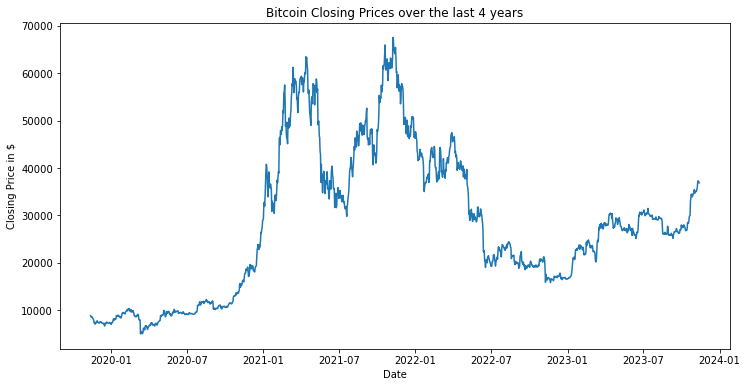

In [97]:
# Graphe des daily closing prices 
plt.figure(figsize=(12, 6))
plt.plot(data['Close'])
plt.title('Bitcoin Closing Prices over the last 4 years')
plt.xlabel('Date')
plt.ylabel('Closing Price in $')
plt.show()

In [98]:
# Stationnarité
from statsmodels.tsa.stattools import adfuller

#Une fonction qui afffiche les résultats de adfuller
def check_stationarity(ts):
    result = adfuller(ts, autolag='AIC')
    print(f'ADF Statistic: {result[0]}')
    print(f'p-value: {result[1]}')
    print('Critical Values:')
    for key, value in result[4].items():
        print(f'   {key}: {value}')

# Checking
check_stationarity(data['Close'])


ADF Statistic: -1.758504623721022
p-value: 0.40124875913517716
Critical Values:
   1%: -3.434908816804013
   5%: -2.863553406963303
   10%: -2.5678419239852994


Vu que la p-value est supérieure à 5%, on va devoir differencier notre time series.

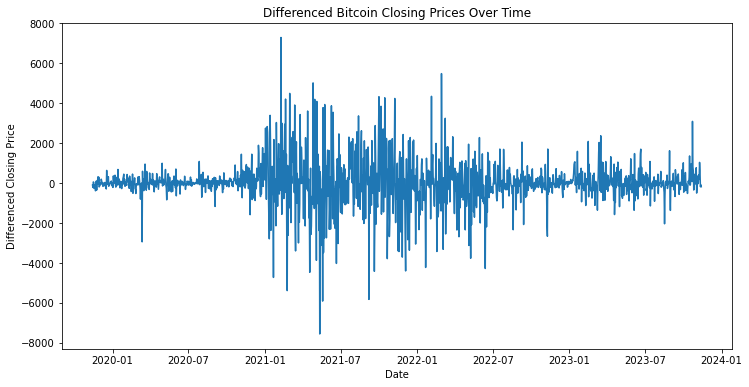

In [99]:
data['Close_diff'] = data['Close'].diff().dropna()

data.dropna(subset=['Close_diff'], inplace=True)

#Affichage de la data differenciée

plt.figure(figsize=(12, 6))
plt.plot(data['Close_diff'])
plt.title('Differenced Bitcoin Closing Prices Over Time')
plt.xlabel('Date')
plt.ylabel('Differenced Closing Price')
plt.show()

/Users/tygeurr/opt/anaconda3/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning:

The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.



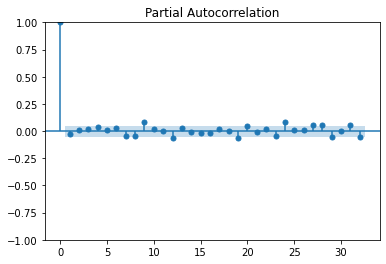

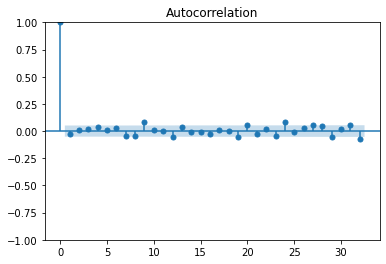

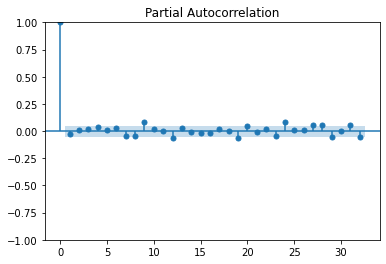

In [132]:
# Plot ACF & PACF
plot_acf(data['Close_diff'].dropna())
plot_pacf(data['Close_diff'].dropna())


In [165]:
# Séparation de la data

train_size = int(len(data) * 0.8)  # 80% of the data for training
train_data, test_data = data.iloc[:train_size], data.iloc[train_size:]

# Train ARIMA model on the training data
p, d, q = 1,1,1 # Honnetement je ne suis pas trop sur de ces chiffres mais j'ai testé tout un tas de triplets
model = ARIMA(train_data['Close_diff'].dropna(), order=(p, d, q))
results = model.fit()

# Affichage des résultats
print(results.summary())


# Mesure Statistique
mse = ((test_data['Close'] - forecast.predicted_mean) ** 2).mean()
rmse = np.sqrt(mse)
print(f'Mean Squared Error: {mse}')


# Forecasting
forecast_days = len(test_data)
forecast = results.get_forecast(steps=forecast_days)


/Users/tygeurr/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/tygeurr/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/tygeurr/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



                               SARIMAX Results                                
Dep. Variable:             Close_diff   No. Observations:                 1168
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -9963.573
Date:                Mon, 13 Nov 2023   AIC                          19933.146
Time:                        14:58:39   BIC                          19948.332
Sample:                    11-14-2019   HQIC                         19938.874
                         - 01-24-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0289      0.023     -1.268      0.205      -0.074       0.016
ma.L1         -1.0000      0.021    -47.909      0.000      -1.041      -0.959
sigma2      1.517e+06   1.38e-08    1.1e+14      0.0

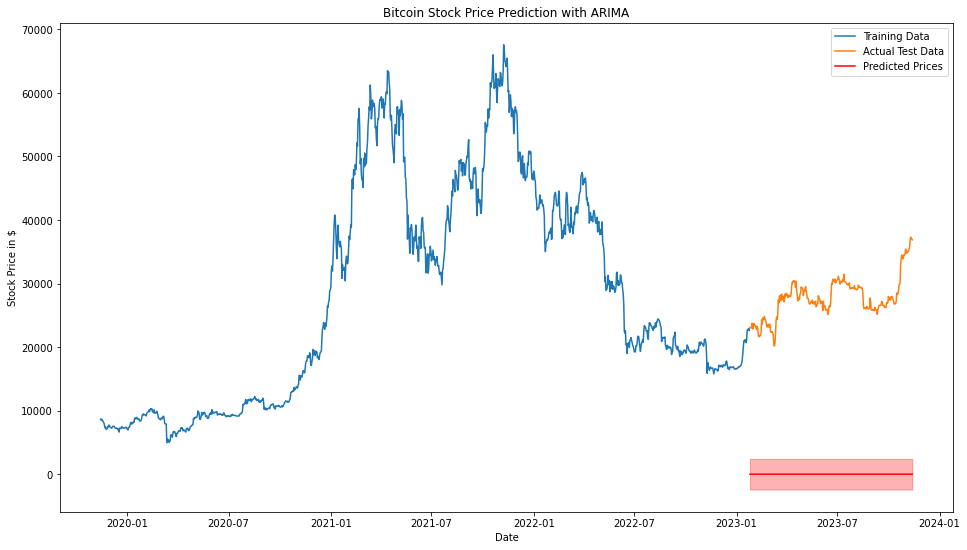

In [168]:


plt.figure(figsize=(16, 9)) 

# Plot du training data
plt.plot(train_data['Close'], label='Training Data')

# Plot de la data test réelle
plt.plot(test_data['Close'], label='Actual Test Data')

# Plot du forecasting
plt.plot(forecast.predicted_mean.index, forecast.predicted_mean, color='red', label='Predicted Prices')

#Intervalle de Confiance
lower_ci_col = 'lower Close_diff' 
upper_ci_col = 'upper Close_diff'  
plt.fill_between(forecast.predicted_mean.index, forecast.conf_int()[lower_ci_col], forecast.conf_int()[upper_ci_col], color='red', alpha=0.3)


plt.title('Bitcoin Stock Price Prediction with ARIMA')
plt.xlabel('Date')
plt.ylabel('Stock Price in $')
plt.legend()
plt.show()

Conclusion: I failed 🥲. Je ne comprends pas trop pourquoi d'ailleurs j'ai testé plusieurs ordres et je crois avoir tout bien fait ... Je reviendrai une fois que j'aurais mieux compris les Times Series.
.
.
.
9/9/2023


# _Ethereum Analysis_

In [3]:
#Visualisation Etherium

df= yf.download(tickers='ETH-USD', period='4y', interval='1d')


fig = go.Figure(data=[go.Candlestick(x=df.index,
                open=df['Open'],
                high=df['High'],
                low=df['Low'],
                close=df['Close'], name = 'Etherium Live Market Data')])

fig.update_layout(
    title='Etherium Market Data',
    yaxis_title='Stock Price in $')

fig.update_xaxes(
    rangeslider_visible=True,
    rangeselector=dict(
        buttons=list([
            dict(count=7, label="1 Week", step="day", stepmode="backward"),
            dict(count=1, label="1 Month", step="month", stepmode="backward"),
            dict(count=3, label="3 Months", step="month", stepmode="backward"),
            dict(count=6, label="6 Months", step="month", stepmode="backward"),
            dict(count=1, label="1 Year", step="year", stepmode="backward"),
            dict(step="all")
        ])
    )
)

fig.show()

[*********************100%%**********************]  1 of 1 completed
